Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [17]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

df_raw = pd.read_csv('../data/msrp.csv')

# EDA

In [2]:
df_raw.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
## Target Variable Distribution (regression)
df_raw['MSRP'].hist(bins=100)

<AxesSubplot:>

<AxesSubplot:xlabel='MSRP', ylabel='Engine HP'>

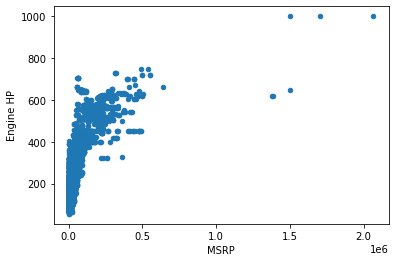

In [4]:
df_raw.plot.scatter('MSRP', 'Engine HP')

In [5]:
df_raw.select_dtypes('object').nunique().sort_values()

Vehicle Size           3
Driven_Wheels          4
Transmission Type      5
Engine Fuel Type      10
Vehicle Style         16
Make                  48
Market Category       71
Model                915
dtype: int64

# Wrangle Data

- Wrangle According to Visualizations Above

In [6]:
## Wrangle function from Assign21
def wrangle(df):
    df = df.copy()
    
    ## Fix column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    ## Remove Outliers
    df = df[df['msrp'] <= 75000]
    
    ## Reduce high cardinality in 'make'
    df['make'] = [x if x in list(df['make'].value_counts().sort_values().tail(5).index) else 'Other' for x in df['make']]
    
    ## Reduce high cardinality in 'market_category' (maybe remove NaN's)
    df['luxury'] = [x if type(x)==float else 1 if 'Luxury' in x else 0 for x in df['market_category']]
    
    ## 'Model' is going to allow for leakage in a way
    df.drop(columns=['model', 'market_category'], inplace=True)
    
    return df

In [7]:
df = wrangle(df_raw)

In [8]:
df.head()

,make,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,luxury
0,Other,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,26,19,3916,46135,1.0
1,Other,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,19,3916,40650,1.0
2,Other,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,20,3916,36350,1.0
3,Other,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,18,3916,29450,1.0
4,Other,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,18,3916,34500,1.0


# Split Data

- Target Variable
- Feature Matrix
- Train-Test Split

In [15]:
target_reg = 'msrp'
target_class = 'make'
y_reg = df[target_reg]
X_reg = df.drop(columns=target_reg)
y_class = df[target_class]
X_class = df.drop(columns=target_class)

In [16]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_class_train, X_class_val, y_class_train, y_class_val = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Build Model

In [18]:
linreg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
)

linreg.fit(X_reg_train, y_reg_train);

In [28]:
rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50,
                           max_depth=10,
                          random_state=42)
)

rf.fit(X_class_train, y_class_train);

In [33]:
eval_set = [(X_class_val, y_class_val)]

xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    XGBClassifier(random_state=42,
                  eval_set=eval_set,
                  eval_metric='logloss',
                  early_stopping_rounds=10,
                  n_jobs=3,
                  verbose=True)
)

xgb.fit(X_class_train, y_class_train);

# Check Metrics

In [21]:
y_pred = [y_train.mean()]*len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))
print('LinReg Training MAE:', mean_absolute_error(y_train, linreg.predict(X_train)))
print('LinReg Test MAE:', mean_absolute_error(y_test, linreg.predict(X_test)))

Baseline MAE: 12429.751641196048
LinReg Training MAE: 5541.068739006572
LinReg Test MAE: 5529.234746267845


In [29]:
print('RF Baseline Accuracy:', y_class_train.value_counts(normalize=True).max())
print('RF Training Accuracy:', rf.score(X_class_train, y_class_train))
print('RF Validation Accuracy:', rf.score(X_class_val, y_class_val))

RF Baseline Accuracy: 0.6208157203244602
RF Training Accuracy: 0.9449331657717354
RF Validation Accuracy: 0.9428962996802193


In [35]:
print('XGB Training Accuracy:', xgb.score(X_class_train, y_class_train))
print('XGB Validation Accuracy:', xgb.score(X_class_val, y_class_val))

XGB Training Accuracy: 1.0
XGB Validation Accuracy: 1.0


# Communicate Results

## Linear Regression model:

 - predicts msrp price given the data
 - performs fairly well with little tuning
 - final error on test data predictions is +/- $\$5,529$

## Random Forest model:

 - predicts brand of car \[Chevrolet, Toyota, Dodge, Volkswagen, Ford, Other]
 - performs extremely well but could possibly be overfit

## XGBoost model:

 - alternative model to Random Forest
 - extremely overfit

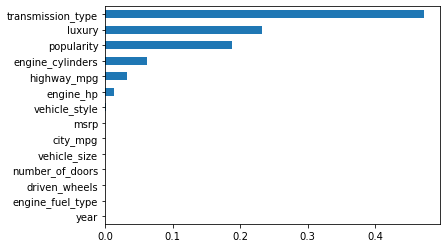

In [45]:
import matplotlib.pyplot as plt

cols = X_class_train.columns
feat_imp = pd.Series(xgb[3].feature_importances_, index=cols).sort_values()
feat_imp.plot.barh();